## Supermarket Facility Location Problem


with real-valued metaheuristic optimisation.

The **facility location** problem is about finding the best locations for some facilities. With a list of cities, some supermarkets are to be build in them. The supermarkets can be in or out of the cities. Population is assumed to be living in the cities only. We are looking to minimise the total travel time for all customers. Data is in `supermarket_cities_locations.csv` and `supermarket_cities_populations.csv`. Approaches used are Random Search, Particle Swarm Optimisation and Covariance Matrix Adaptation (CMA) in an experimental way


In [2]:
# importing the required libraries
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import cma
import time
import pyswarms as ps
import itertools
import pandas as pd

In [1]:
def total_travel_time(x, c, p):
    # x: locations of supermarkets (ie genotype), shape eg (5, 2)
    # c: locations of cities, shape eg (20, 2)
    # p: populations of cities, shape eg (20,)

    # assume that everyone travels to the supermarket exactly once per
    # week

    # assume that travel time is exactly proportional to Euclidean
    # distance from city to supermarket
    
    # calculate all city-supermarket distances. with (eg) 20 cities
    # and 5 supermarkets, we'll have d.shape = (20, 5)
    d = cdist(c, x)
    # everyone in city i will travel to their nearest supermarket,
    # so we need minimum distance from each city to any supermarket.
    dmin = np.min(d, axis=1)
    # there are p[i] people in city i, each travelling a distance
    # dmin[i], so multiply and sum for total travel time
    return np.sum(dmin * p)

def plot(x, c, p):
    # solutions will be of shape (eg) (10,)
    # but we interpret as shape (5, 2)
    x = x.reshape((-1, 2))
    plt.figure(figsize=(6, 5))
    plt.scatter(c[:, 0], c[:, 1], s=p/10000, label="Cities") # s gives size
    plt.scatter(x[:, 0], x[:, 1], marker="*", label="Supermarkets") # stars for supermarkets
    plt.gca().set_aspect('equal')
    plt.legend()
    plt.savefig("supermarket.pdf")
    plt.show()
    plt.close()


In [4]:
# function to perform random search function
def perform_rs(params):
    """
    Here, we have two approaches:
    1. we can create all possible candidates at once, calculate the objectives for all and select the best value using max or min. Or
    2. we can use for-loop to create candidates one by one, and keeping only the values that give the best objective value so far.
    
    There is time vs space trade-off, i.e. For the first approach, the time taken by the algorithm is less but it takes more space as 
    we perform and keep all the calculations before selecting the best, While the second approach takes more time but less space as we 
    evaluate one solution at a time.
    """
    # getting the required values from parameter dictionary params
    cities, populations = params["cities"], params["populations"]
    maxits = params["maxits"]
    n_markets = params["n_markets"]
    d = params["dimensions"]
    seed = params["seed"]
    
    # setting the random seed 
    np.random.seed(seed)
    # creating all possible candidates at once 
    candidates = np.random.random(size = (maxits, n_markets, dimensions))
    val = min(candidates, key = lambda x: total_travel_time(x, cities, populations))
    # returning the cost and solution
    return round(total_travel_time(val, cities, populations)), val

In [5]:
# function to perform cma
def perform_cma(params):
    # getting the required values from parameter dictionary params
    cities, populations = params["cities"], params["populations"]
    maxits = params["maxits"]
    n_markets = params["n_markets"]
    d = params["dimensions"]
    seed = params["seed"]
    bounds = params["bounds"]
    
    # estimating initial mean and sigma for cma
    mean_vec = [(lb + ub) / 2 for lb, ub in zip(bounds[0], bounds[1])]
    sigma_value = sum(mean_vec) / len(mean_vec)
    
    # passing sigma as an average value of 0.5, and vector of 10, to be reshaped to (5, 2)
    es = cma.CMAEvolutionStrategy(mean_vec, sigma_value, {'bounds': bounds, 'seed': seed + 1})
    
    # using lambda to call a function with additional parameters
    es.optimize(lambda x: total_travel_time(x.reshape((n_markets, d)), cities, populations), iterations = maxits / es.popsize)
    # obtaining the best value
    val = es.best.x.reshape((n_markets, d))
    # returning the cost and solution
    return round(total_travel_time(val, cities, populations)), val

In [6]:
# function to reshape the vector in compatible format and calculate the cost
def get_population_cost(pop_loc, popsize, params):
    # getting the required values
    cities, populations = params["cities"], params["populations"]
    n_markets = params["n_markets"]
    d = params["dimensions"]
    
    # reshaping the vector into (5,2) shaped solution arrays, 
    # total number of such candidate solution arrays is equal to the number of particles  
    pop_loc = pop_loc.reshape((popsize, n_markets * d))
    costs = []    # variable to store the costs of all particles
    for loc in pop_loc:
        # calculation of cost of each particle
        costs.append(total_travel_time(loc.reshape((n_markets, d)), cities, populations))
    return np.array(costs)

# function to execute Particle Swarm Optimization
def perform_pso(params):
    # getting the required values from parameter dictionary params
    cities, populations = params["cities"], params["populations"]
    maxits = params["maxits"]
    n_markets = params["n_markets"]
    d = params["dimensions"]
    seed = params["seed"]
    bounds = params["bounds"]
    
    # popping population parameter so the remaining dictionary can directly go to options parameter
    popsize = params["hyper_params_pso"].pop("popsize")
    options = params["hyper_params_pso"]
    # setting the random seed
    np.random.seed(seed)
    
    # Call instance of PSO with bounds argument
    optimizer = ps.single.GlobalBestPSO(n_particles = popsize, dimensions = n_markets * d, options = options, bounds = bounds)
    # Perform optimization
    cost, pos = optimizer.optimize(lambda x: get_population_cost(x, popsize, params), round(maxits / popsize))
    # returning the cost and solution
    return round(cost), pos.reshape((n_markets, d))

In [7]:
# function to compare the current best ever solution to new solution
#  and return the min cost and best ever solution
def get_best_sol(min_time, best_loc, travel_time, loc):
    if min_time == -1 or travel_time < min_time:
        return travel_time, loc
    else:
        return min_time, best_loc

# method to run different functions and record values obtained
def run_func(func, params, performance, min_time, best_loc, comb_info = None):
    st_time = time.time()    # using time package to calculate the time taken
    travel_time, loc = func(params)
    time_taken = time.time() - st_time
    # recording the result
    row_format = {"perform_rs": ["RS", np.nan, np.nan, np.nan, np.nan, travel_time, time_taken],
                 "perform_cma": ["CMA", np.nan, np.nan, np.nan, np.nan, travel_time, time_taken]}
    try:
        performance.loc[len(performance)] = row_format[func.__name__]
    except:
        performance.loc[len(performance)] = ["PSO", comb_info["popsize"], comb_info["w"], 
                                             comb_info["c2"], comb_info["c1"], travel_time, time_taken]
    min_time, best_loc = get_best_sol(min_time, best_loc, travel_time, loc)
    return performance, min_time, best_loc

In [8]:
# reading the values from files
cities = np.genfromtxt("supermarket_city_locations.csv")
populations = np.genfromtxt("supermarket_city_populations.csv")
nsupermarkets = 5
# common parameters
maxits = 20000
reps = 5
dimensions = 2

In [23]:
# defining a single dictionary of parameters to be sent to methods, 
params = {"cities": cities,
         "populations": populations,
         "n_markets": nsupermarkets,
         "maxits": maxits,
         "dimensions": dimensions,
         "bounds": [np.zeros(nsupermarkets * dimensions), np.ones(nsupermarkets * dimensions)]}

# hyper_parameters to be run for Particle Swarm optimization
"""
# popsize is taken as 30 and 100 to evaluate the effect of increase in population size
# w = 0.1 and 0.9 creates the difference between being exploitative and explorative respectively
# c1 and c2 value combinations help us evaluate the difference between giving weightages either to global best or personal best
"""

# 
hyper_params_pso = {"popsize": [30, 100], "c1": [0.5, 2], "c2": [0.5, 2], "w": [0.1, 0.9]}

# keeping all the combinations of the hyperparameters
combinations = [dict(zip(hyper_params_pso, x)) for x in itertools.product(*hyper_params_pso.values())]

min_time, best_loc = -1, 0     # variables to store min_cost and corresponding best ever solution
# storing performance of runs for further evaluation
performance = pd.DataFrame(columns = ["Algorithm", "popsize", "w", "$φ_g$", "$φ_p$", "cost", "time_taken"])
for run in range(reps):
    # setting seed to send to methods
    params["seed"] = run
    for func in [perform_rs, perform_cma, perform_pso]:
        if func != perform_pso:
            performance, min_time, best_loc = run_func(func, params, performance, min_time, best_loc)
        else:
             for c in combinations:
                params["hyper_params_pso"] = dict(c)
                performance, min_time, best_loc = run_func(func, params, performance, min_time, best_loc, c)    
   

(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1, Sat Nov 20 17:28:02 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 5.852509247485390e+05 1.0e+00 4.65e-01  5e-01  5e-01 0:00.0
    2     20 1.051997011494939e+06 1.1e+00 4.59e-01  4e-01  5e-01 0:00.0
    3     30 8.583906609170906e+05 1.2e+00 4.35e-01  4e-01  5e-01 0:00.0
  100   1000 3.128758151330567e+05 4.3e+00 5.31e-02  2e-02  5e-02 0:00.2
  200   2000 2.001464419621159e+05 2.4e+01 1.16e-03  7e-05  1e-03 0:00.4
  300   3000 1.867703523649660e+05 5.3e+01 3.37e-04  6e-06  3e-04 0:00.6
  400   4000 1.867092679309580e+05 3.5e+02 1.99e-05  2e-07  5e-05 0:00.8
  500   5000 1.856714859190141e+05 5.1e+02 5.31e-04  2e-06  8e-04 0:00.9
  600   6000 1.856164461062869e+05 1.8e+02 7.00e-06  2e-08  3e-06 0:01.1
  700   7000 1.856160349785404e+05 1.3e+02 2.05e-08  2e-11  3e-09 0:01.3
  783   7830 1.856160345872774e+05 1.3e+02 1.42e-10  9e-14  1e-11 0:01.5


2021-11-20 17:28:05,812 - pyswarms.single.global_best - INFO - Optimize for 667 iters with {'c1': 0.5, 'c2': 0.5, 'w': 0.1}
pyswarms.single.global_best: 100%|██████████████████████████████████████████████████████████|667/667, best_cost=2.71e+5
2021-11-20 17:28:07,003 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 271044.041464839, best pos: [0.79416104 0.77220129 0.26208082 0.48097103 0.54197378 0.53015285
 0.64975082 0.40296955 0.70742    0.70594827]
2021-11-20 17:28:07,016 - pyswarms.single.global_best - INFO - Optimize for 667 iters with {'c1': 0.5, 'c2': 0.5, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████████████████████████████████████████████████████|667/667, best_cost=1.91e+5
2021-11-20 17:28:08,258 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 190527.95126554326, best pos: [0.54057485 0.52258141 0.10498714 0.69020945 0.64830293 0.40228243
 0.10804365 0.37461971 0.82095061 0.76863038]
2021-11-20 17:28:08,267 - pyswar

(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=2, Sat Nov 20 17:28:22 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 7.171684160324037e+05 1.0e+00 5.07e-01  5e-01  5e-01 0:00.0
    2     20 8.387962245471483e+05 1.2e+00 5.14e-01  5e-01  5e-01 0:00.0
    3     30 6.474444815777789e+05 1.4e+00 5.13e-01  5e-01  5e-01 0:00.0
  100   1000 4.536692454188730e+05 5.0e+00 8.43e-02  3e-02  9e-02 0:00.2
  200   2000 3.334002587104413e+05 2.8e+01 5.14e-04  3e-05  6e-04 0:00.4
  300   3000 3.287779335251303e+05 3.4e+02 3.31e-04  5e-06  1e-03 0:00.6
  400   4000 2.154426914718915e+05 4.6e+02 3.75e-02  2e-04  6e-02 0:00.8
  500   5000 1.970042927773215e+05 1.0e+02 9.01e-04  4e-06  3e-04 0:00.9
  600   6000 1.963154149288632e+05 5.8e+01 5.93e-04  1e-06  8e-05 0:01.1
  700   7000 1.962744884364452e+05 6.0e+01 3.04e-06  4e-09  2e-07 0:01.3
  800   8000 1.962743845595460e+05 4.5e+01 3.92e-09  3e-12  1e-10 0:01.5
  836   8360 1.962743845156769e+05 5.4

2021-11-20 17:28:26,101 - pyswarms.single.global_best - INFO - Optimize for 667 iters with {'c1': 0.5, 'c2': 0.5, 'w': 0.1}
pyswarms.single.global_best: 100%|██████████████████████████████████████████████████████████|667/667, best_cost=4.19e+5
2021-11-20 17:28:27,198 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 419095.8451632304, best pos: [0.80756446 0.78149792 0.64049147 0.43253334 0.42514719 0.84694536
 0.60485352 0.58506001 0.2628804  0.67003684]
2021-11-20 17:28:27,210 - pyswarms.single.global_best - INFO - Optimize for 667 iters with {'c1': 0.5, 'c2': 0.5, 'w': 0.9}
pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████|667/667, best_cost=2.7e+5
2021-11-20 17:28:28,415 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 269734.6451199646, best pos: [0.54305543 0.53276502 0.64831088 0.40237554 0.57197534 0.14184175
 0.30803372 0.57757985 0.81373621 0.80379391]
2021-11-20 17:28:28,425 - pyswar

(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=3, Sat Nov 20 17:28:41 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 8.468522657055068e+05 1.0e+00 4.52e-01  4e-01  5e-01 0:00.0
    2     20 7.978970141630846e+05 1.1e+00 4.23e-01  4e-01  4e-01 0:00.0
    3     30 8.028632962317240e+05 1.2e+00 4.32e-01  4e-01  5e-01 0:00.0
  100   1000 1.976334552742284e+05 6.6e+00 1.95e-02  4e-03  2e-02 0:00.2
  200   2000 1.714341174121220e+05 3.3e+01 7.07e-04  3e-05  1e-03 0:00.4
  300   3000 1.709316445268095e+05 4.0e+01 5.74e-06  1e-07  4e-06 0:00.6
  400   4000 1.709304679886324e+05 4.2e+01 2.79e-08  2e-10  8e-09 0:00.7
  500   5000 1.709304639066659e+05 5.4e+01 1.26e-10  4e-13  2e-11 0:00.9
  506   5060 1.709304639049082e+05 5.0e+01 7.55e-11  2e-13  1e-11 0:00.9


2021-11-20 17:28:44,308 - pyswarms.single.global_best - INFO - Optimize for 667 iters with {'c1': 0.5, 'c2': 0.5, 'w': 0.1}
pyswarms.single.global_best: 100%|██████████████████████████████████████████████████████████|667/667, best_cost=2.79e+5
2021-11-20 17:28:45,434 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 279252.3106240558, best pos: [0.81127936 0.76736002 0.35846673 0.65589664 0.64831361 0.4023854
 0.54141208 0.54675735 0.37386744 0.43978782]
2021-11-20 17:28:45,443 - pyswarms.single.global_best - INFO - Optimize for 667 iters with {'c1': 0.5, 'c2': 0.5, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████████████████████████████████████████████████████|667/667, best_cost=2.23e+5
2021-11-20 17:28:46,655 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 222688.44954068665, best pos: [0.65570792 0.40839644 0.53658431 0.52402581 0.1308994  0.39037054
 0.17514177 0.72725979 0.81739784 0.77705217]
2021-11-20 17:28:46,666 - pyswar

(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=4, Sat Nov 20 17:29:00 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 6.693792521302680e+05 1.0e+00 4.35e-01  4e-01  4e-01 0:00.0
    2     20 8.864106762281227e+05 1.1e+00 3.74e-01  4e-01  4e-01 0:00.0
    3     30 8.867477719628537e+05 1.1e+00 3.70e-01  3e-01  4e-01 0:00.0
  100   1000 1.907761097271345e+05 1.2e+01 4.49e-03  7e-04  6e-03 0:00.2
  200   2000 1.791306627442082e+05 5.3e+01 1.89e-04  7e-06  3e-04 0:00.3
  300   3000 1.761218543932395e+05 4.5e+02 1.24e-03  2e-05  6e-03 0:00.5
  400   4000 1.709535743784637e+05 7.0e+01 1.62e-04  1e-06  8e-05 0:00.7
  500   5000 1.709305262299992e+05 4.7e+01 7.58e-07  3e-09  1e-07 0:00.8
  600   6000 1.709304639329913e+05 3.8e+01 1.28e-09  3e-12  8e-11 0:01.0
  631   6310 1.709304639045482e+05 4.8e+01 1.78e-10  2e-13  1e-11 0:01.0


2021-11-20 17:29:03,001 - pyswarms.single.global_best - INFO - Optimize for 667 iters with {'c1': 0.5, 'c2': 0.5, 'w': 0.1}
pyswarms.single.global_best: 100%|██████████████████████████████████████████████████████████|667/667, best_cost=3.21e+5
2021-11-20 17:29:04,116 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 320855.71997945156, best pos: [0.64513106 0.32552669 0.25644935 0.39923286 0.76604613 0.76457296
 0.57179246 0.54351593 0.64835069 0.40267872]
2021-11-20 17:29:04,128 - pyswarms.single.global_best - INFO - Optimize for 667 iters with {'c1': 0.5, 'c2': 0.5, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████████████████████████████████████████████████████|667/667, best_cost=2.24e+5
2021-11-20 17:29:05,319 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 224251.54764886957, best pos: [0.10800988 0.55077028 0.46895694 0.22082782 0.80880754 0.77108592
 0.64787621 0.40202587 0.53316326 0.52529132]
2021-11-20 17:29:05,329 - pysw

(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=5, Sat Nov 20 17:29:18 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 8.687216504917757e+05 1.0e+00 4.48e-01  4e-01  5e-01 0:00.0
    2     20 9.161641654850510e+05 1.1e+00 4.02e-01  4e-01  4e-01 0:00.0
    3     30 6.524826607064110e+05 1.2e+00 3.55e-01  3e-01  4e-01 0:00.0
  100   1000 2.378117255322537e+05 6.4e+00 3.16e-02  8e-03  4e-02 0:00.2
  200   2000 1.931185088206782e+05 3.8e+01 3.04e-04  2e-05  4e-04 0:00.4
  300   3000 1.857340069203898e+05 5.1e+01 3.24e-04  8e-06  3e-04 0:00.6
  400   4000 1.856162659479284e+05 9.0e+01 1.97e-06  2e-08  1e-06 0:00.8
  500   5000 1.856160349038579e+05 1.1e+02 4.36e-09  2e-11  2e-09 0:01.0
  581   5810 1.856160345875583e+05 8.9e+01 5.27e-11  1e-13  1e-11 0:01.1


2021-11-20 17:29:21,713 - pyswarms.single.global_best - INFO - Optimize for 667 iters with {'c1': 0.5, 'c2': 0.5, 'w': 0.1}
pyswarms.single.global_best: 100%|██████████████████████████████████████████████████████████|667/667, best_cost=3.19e+5
2021-11-20 17:29:22,882 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 319107.0633437477, best pos: [0.54610789 0.70884566 0.64423928 0.40379862 0.17126483 0.46043585
 0.78580402 0.737443   0.50830449 0.5052155 ]
2021-11-20 17:29:22,891 - pyswarms.single.global_best - INFO - Optimize for 667 iters with {'c1': 0.5, 'c2': 0.5, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████████████████████████████████████████████████████|667/667, best_cost=2.04e+5
2021-11-20 17:29:24,107 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 203992.03156837495, best pos: [0.65117943 0.39634441 0.53504835 0.52997227 0.84442741 0.98018399
 0.09516295 0.45219459 0.79236718 0.76199964]
2021-11-20 17:29:24,117 - pyswa

In [26]:
# filling na with -1 to help with grouping (which otherwise will drop na values)
performance = performance.fillna("na")
# using the algorithm name and parameters to identify each group of experiment
group_by_cols = ["Algorithm", "popsize", "w", "$φ_g$", "$φ_p$"]

# calculating the mean, stddev, minimum cost and average time of a group 
performance["mean"] = performance.groupby(by = group_by_cols, as_index = False)['cost'].transform(lambda x: int(round(x.mean())))
performance["stddev"] = performance.groupby(by = group_by_cols, as_index = False)['cost'].transform(lambda x: int(round(x.std())))
performance["min"] = performance.groupby(by = group_by_cols, as_index = False)['cost'].transform(lambda x: int(round(x.min())))
performance["time"] = performance.groupby(by = group_by_cols, as_index = False)['time_taken'].transform(lambda x: round(x.mean(), 2))

# storing the results in result_df and grouping along with value aggregation 
result_df = performance.groupby(by = ["Algorithm", 
                          "popsize", 
                          "w", "$φ_g$", 
                          "$φ_p$"], as_index = False).agg({"min": "min", "mean": "first", "stddev": "first",
                                         "time": "first"})
# values of each group of iterations
result_df

,Algorithm,popsize,w,$φ_g$,$φ_p$,min,mean,stddev,time
0,CMA,na,na,na,na,170930,181873,10896,3.07
1,PSO,30,0.1,0.5,0.5,271044,321871,58867,1.15
2,PSO,30,0.1,0.5,2,265576,284508,12627,1.18
3,PSO,30,0.1,2,0.5,200737,209742,9548,1.16
4,PSO,30,0.1,2,2,170934,171195,310,1.17
5,PSO,30,0.9,0.5,0.5,190528,222239,29994,1.22
6,PSO,30,0.9,0.5,2,349862,375602,22479,1.25
7,PSO,30,0.9,2,0.5,346118,371143,15137,1.23
8,PSO,30,0.9,2,2,245688,328565,51537,1.25
9,PSO,100,0.1,0.5,0.5,275593,342382,38030,0.72


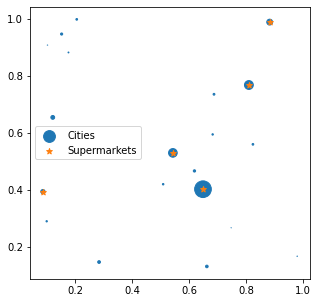

In [28]:
# plot of best solution ever found
plot(best_loc, cities, populations)

<h4>Observations</h4>

From the values in the above shown table, it can be observed that although Random Search is the fastest method, it tends to underperform when compared to other algorithms such as CMA and PSO. Also, PSO gives best results for the given data within a very short time, which tends to be faster and more accurate if we have bigger swarm.<br>
With respect to the best solution plotted, we get lowest cost from PSO when with w = 0.1(exploitative) and equal personal and social influence values = 2, resulting in supermarkets being placed in highly populated clusters.